In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/jruby-1.1.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
X_test_numeric = X_test.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train_numeric.shape)
print(X_test_numeric.shape)

(584, 65)
(147, 65)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 514 samples
  Minority class (True): 70 samples
  Imbalance ratio: 1:7.34

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 514 -> 292 samples
Reduction: 56.8%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 70}
Cluster weights: {0: 1.0}
Cluster 0: 70 -> 292 samples
Minority class: 70 -> 292 samples
Change: 417.1%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final distribution:
  Class False: 292 samples
  Class True: 292 samples
Total samples: 584
Balance 

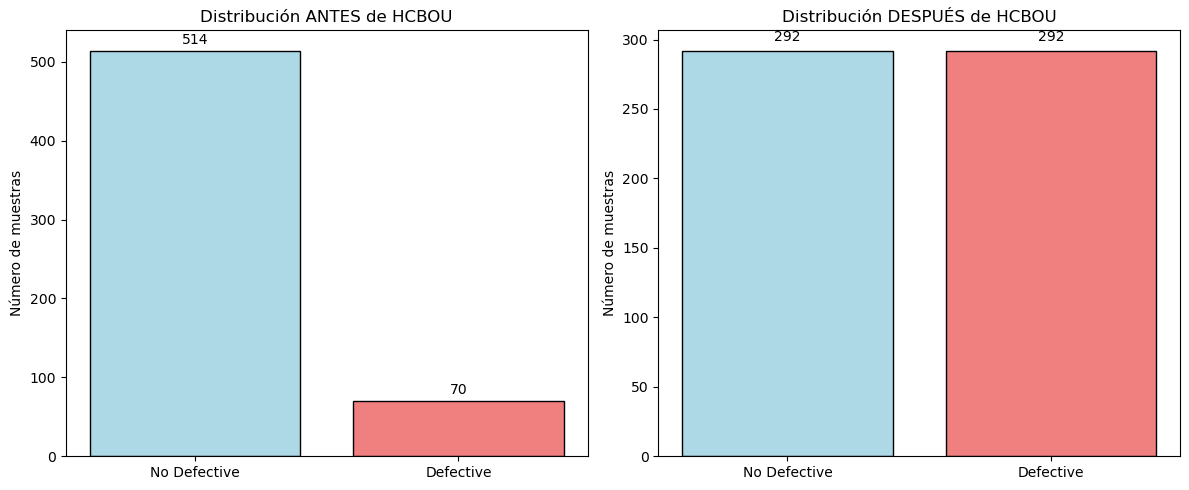


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (584, 65)
Shape final y_train_balanced: (584,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_numeric), columns=X_test_numeric.columns, index=X_test_numeric.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,3.472603,7.885274,458.714041,13.890411,0.722603,1.154110,3.013699,83.501712,1.989726,9.683219,...,10.700342,2.436644,241.722603,156.114726,0.706164,0.540092,0.224315,2.321918,2.145548,1.811644
std,7.980848,9.882440,657.914214,37.598333,4.166571,0.734041,7.944478,133.046117,1.826965,11.069436,...,15.143825,1.939769,477.566141,346.389779,0.213931,0.293023,0.627575,1.208517,1.570869,1.988509
min,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.298851,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,78.000000,1.000000,0.000000,1.000000,0.000000,6.000000,1.000000,4.750000,...,1.000000,1.000000,3.000000,1.000000,0.528923,0.404133,0.000000,1.000000,1.000000,0.000000
50%,0.000000,6.000000,193.500000,5.000000,0.000000,1.000000,0.000000,25.500000,2.000000,8.000000,...,6.000000,2.000000,73.500000,27.000000,0.699770,0.532958,0.000000,2.000000,2.000000,1.000000
75%,3.000000,9.000000,554.000000,11.000000,0.000000,1.000000,2.000000,107.250000,2.000000,12.000000,...,13.000000,4.000000,234.250000,135.000000,0.918226,0.720691,0.000000,3.000000,3.000000,3.000000
max,85.000000,149.000000,3878.000000,384.000000,50.000000,11.000000,124.000000,764.000000,24.000000,150.000000,...,99.000000,8.000000,4687.000000,2706.000000,1.000000,1.000000,3.000000,6.000000,7.000000,8.000000


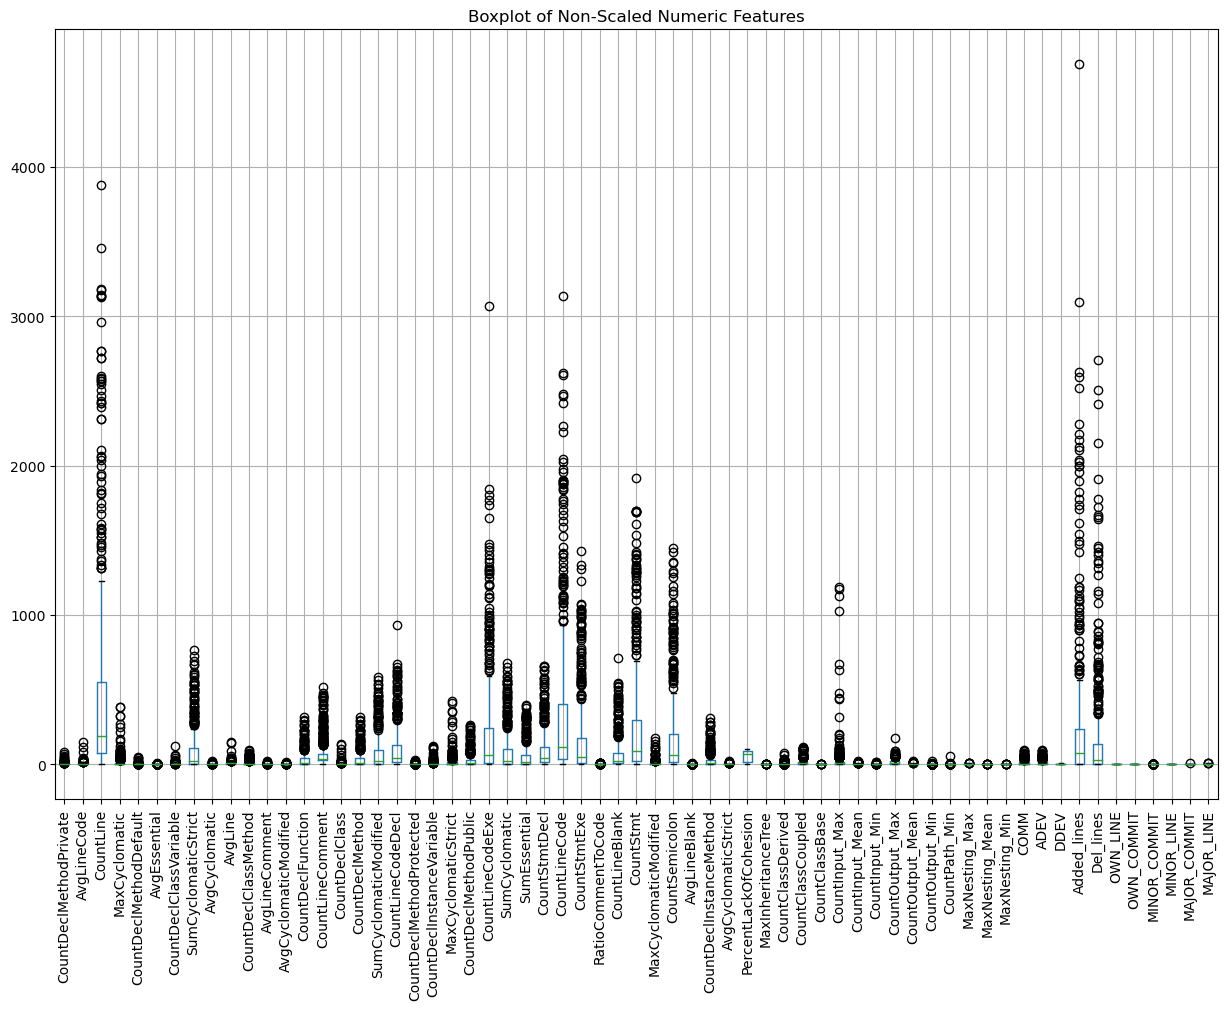

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,...,584.000000,5.840000e+02,584.000000,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02,5.840000e+02
mean,4.866731e-17,1.216683e-17,-4.866731e-17,-2.433366e-17,-6.083414e-18,-1.095014e-16,1.216683e-17,-4.866731e-17,2.433366e-17,-1.216683e-17,...,0.000000,-9.733462e-17,0.000000,-2.433366e-17,-4.623395e-16,-3.528380e-16,-2.433366e-17,-1.460019e-16,9.733462e-17,4.866731e-17
std,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,...,1.000857,1.000857e+00,1.000857,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00,1.000857e+00
min,-4.354900e-01,-7.985916e-01,-6.917374e-01,-3.697589e-01,-1.735773e-01,-1.573616e+00,-3.796703e-01,-6.281528e-01,-1.090022e+00,-8.755207e-01,...,-0.707187,-1.257229e+00,-0.506589,-4.510773e-01,-1.905582e+00,-1.844753e+00,-3.577379e-01,-1.922942e+00,-1.367006e+00,-9.118372e-01
25%,-4.354900e-01,-4.947626e-01,-5.791643e-01,-3.431392e-01,-1.735773e-01,-2.101267e-01,-3.796703e-01,-5.830170e-01,-5.421967e-01,-4.460433e-01,...,-0.641097,-7.412612e-01,-0.500302,-4.481879e-01,-8.292105e-01,-4.643836e-01,-3.577379e-01,-1.094772e+00,-7.298698e-01,-9.118372e-01
50%,-4.354900e-01,-1.909336e-01,-4.034590e-01,-2.366603e-01,-1.735773e-01,-2.101267e-01,-3.796703e-01,-4.363257e-01,5.628340e-03,-1.521904e-01,...,-0.310646,-2.252939e-01,-0.352552,-3.730636e-01,-2.991736e-02,-2.436471e-02,-3.577379e-01,-2.666026e-01,-9.273383e-02,-4.085169e-01
75%,-5.926787e-02,1.128954e-01,1.449545e-01,-7.694194e-02,-1.735773e-01,-2.101267e-01,-1.277073e-01,1.786497e-01,5.628340e-03,2.094747e-01,...,0.151985,8.066407e-01,-0.015661,-6.100881e-02,9.921095e-01,6.168604e-01,-3.577379e-01,5.615671e-01,5.444021e-01,5.981239e-01
max,1.022414e+01,1.429158e+01,5.201616e+00,9.852215e+00,1.183699e+01,1.342476e+01,1.524204e+01,5.119140e+00,1.205778e+01,1.268692e+01,...,5.835735,2.870510e+00,9.316172,7.367628e+00,1.374684e+00,1.570876e+00,4.426666e+00,3.046076e+00,3.092946e+00,3.114726e+00


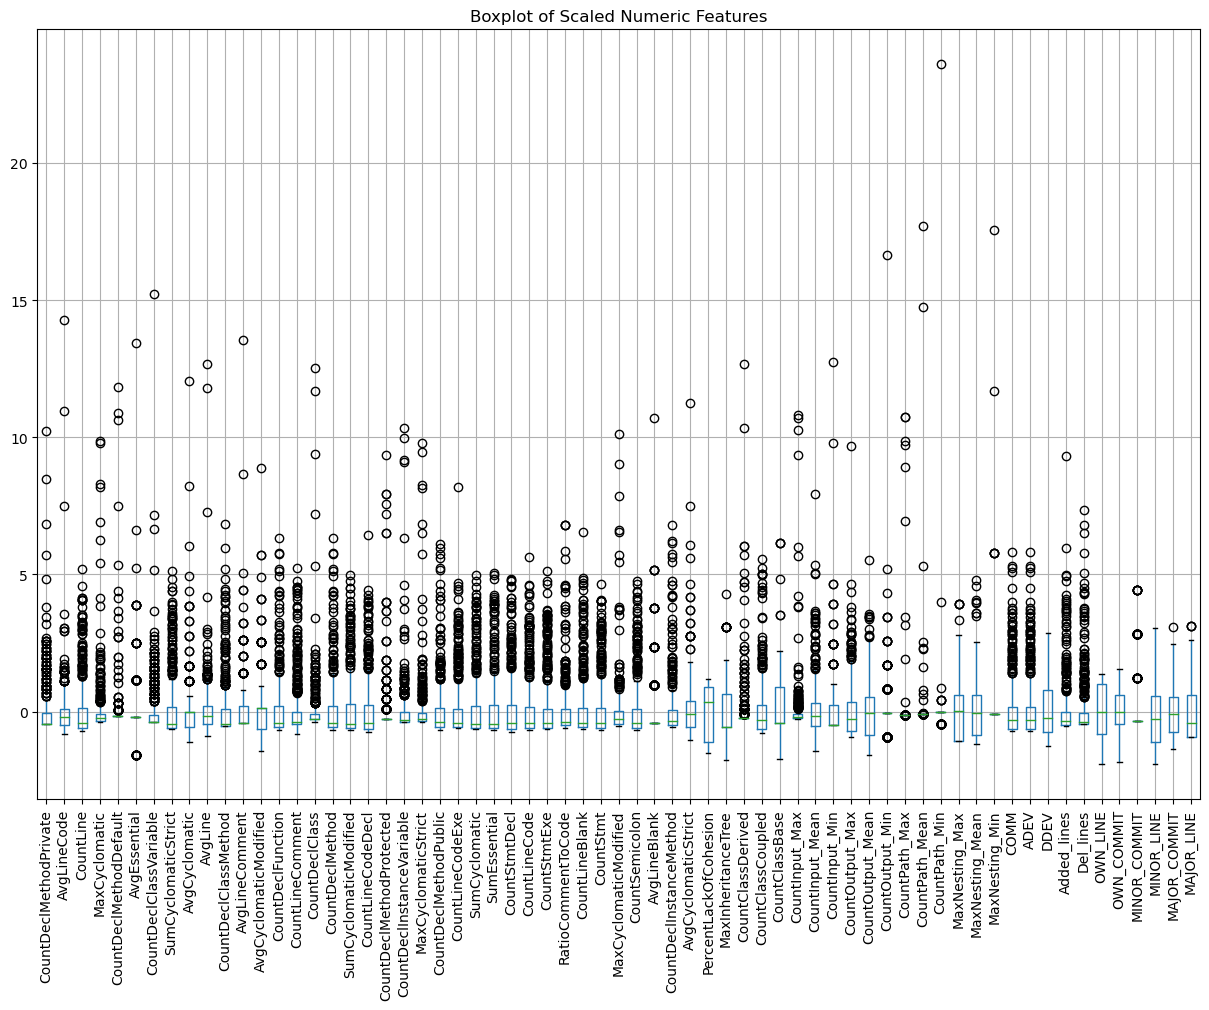

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Export the balanced and scaled training set to CSV files
X_train_balanced_scaled.to_csv('../classification/hcbou/jruby-1.1-hcbou-train-features-balanced-scaled.csv', index=False)
y_train_balanced.to_csv('../classification/hcbou/jruby-1.1-hcbou-train-labels-balanced.csv', index=False)
X_test_scaled.to_csv('../classification/hcbou/jruby-1.1-hcbou-test-features-scaled.csv', index=False)
y_test.to_csv('../classification/hcbou/jruby-1.1-hcbou-test-labels.csv', index=False)